In [1]:
import sys
sys.path.insert(0, "/home/myellapragad/spring25/ZoomLDM/")

from datasets import load_dataset
from omegaconf import OmegaConf

import numpy as np
import torch
from einops import rearrange
from huggingface_hub import hf_hub_download
from IPython.utils import io
from torch.utils.data import DataLoader

from ldm.models.diffusion.plms import PLMSSampler
from ldm.util import instantiate_from_config
from utils import collate_fn, show

In [2]:
MAG = "20x"
DDIM_STEPS = 50
SCALE = 2
shape = [3,64,64]

### Load dataset

In [3]:
ds = load_dataset("StonyBrook-CVLab/ZoomLDM-demo-dataset", name=MAG, trust_remote_code=True, split='train')
dl = DataLoader(ds, batch_size=8, collate_fn = collate_fn)
batch = next(iter(dl))

Repo card metadata block was not found. Setting CardData to empty.


### Load ZoomLDM

In [4]:
device = torch.device('cuda')

ckpt_path = hf_hub_download(repo_id="StonyBrook-CVLab/ZoomLDM", filename="brca/weights.ckpt")
state_dict = torch.load(ckpt_path, weights_only=False)

config_path = hf_hub_download(repo_id="StonyBrook-CVLab/ZoomLDM", filename="brca/config.yaml")
config = OmegaConf.load(config_path)

with io.capture_output() as _:
    model = instantiate_from_config(config.model)
model = model.to(device).eval()
model.load_state_dict(state_dict);

# disable null token 
model.cond_stage_model.p_uncond = 0
sampler = PLMSSampler(model)

## Sample

In [5]:
with torch.no_grad(), model.ema_scope(), torch.autocast(dtype=torch.float16, device_type="cuda"):
    for k in ['ssl_feat', 'mag']:
        batch[k] = batch[k].to(device)

    cc = model.get_learned_conditioning(batch)
    uc = torch.zeros_like(cc)

    samples_ddim, _ = sampler.sample(
        S=DDIM_STEPS,
        conditioning=cc,
        batch_size=len(batch["ssl_feat"]),
        shape=shape,
        verbose=False,
        unconditional_guidance_scale=SCALE,
        unconditional_conditioning=uc,
    )

    x_samples_ddim = model.decode_first_stage(samples_ddim)
    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples_ddim = (255 * x_samples_ddim.cpu().numpy()).astype(np.uint8)

/home/myellapragad/spring24/sd/ldm/models/diffusion/ddpm.py:1087: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


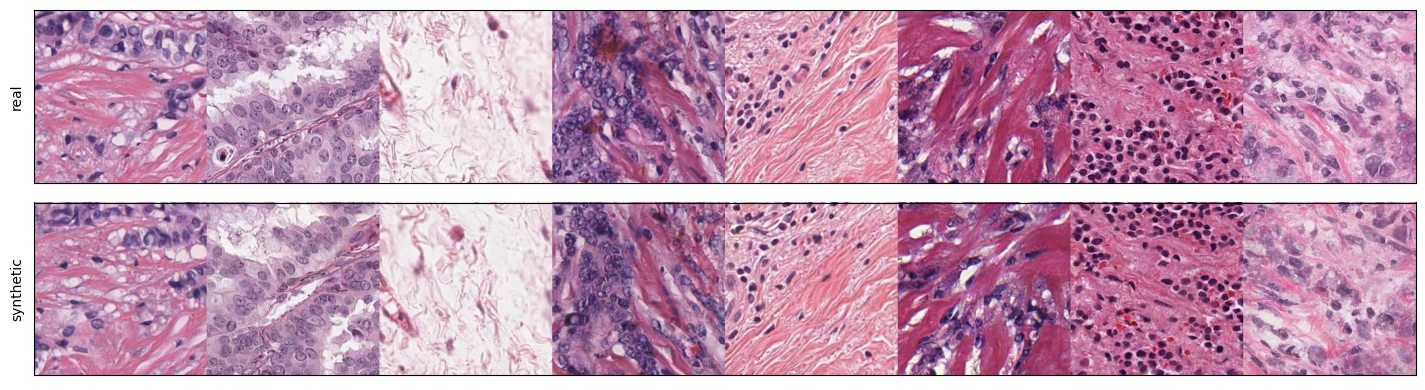

In [6]:
real = rearrange(batch['image'], "n h w c -> h (n w) c")

syn = rearrange(x_samples_ddim, "n c h w -> h (n w) c")

show([real, syn], ["real", "synthetic"])